### BP Smoky Mountain Data Challenge

#### Author: Jonathan Sheng


In [ ]:
import segpy
from segpy.reader import create_reader
from segpy.writer import write_segy

import math
import matplotlib as plot
import matplotlib.pyplot
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image
import random

import os
import sys

import cv2
import pickle

import sklearn
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

# Standard Deviation Code
Run across all realizations to find standard deviation for each pixel. 

In [24]:
#Use this to access large st deviation matrix
with open('large_deviation.pickle', 'rb') as f:
     deviations= pickle.load(f) #deviations

In [ ]:
"""
Example of loading a single 2D realization from a single file into a 2D numpy array, with x
as your leading dimension and z as your innermost dimension. We know the x and z dimensions
(1058 and 400) from the SEGY header printed by the cell above.
"""
REALIZATIONS = 1000
deviations = np.zeros((1058, 400))
means = np.zeros((1058, 400))
totals = np.zeros((1058, 400))
PATH = "C:/Users/19174/Desktop/BP HPC/large_dataset_only_realizations"
                    

In [ ]:
random_std = []
for file in os.listdir(PATH):
    if file.endswith(".stack.segy"):
        print(file)
        path = "C:/Users/19174/Desktop/BP HPC/large_dataset_only_realizations/"+ file
        with open(path, 'rb') as segy_in_file:
            segy_reader = create_reader(segy_in_file, endian='>')
            for trace_index in segy_reader.trace_indexes():
                data = segy_reader.trace_samples(trace_index)
                for i in range(len(data)):
                    means[trace_index, i] += data[i]/REALIZATIONS #Collecting means, storing in array
                    temp = random.randint(0, 423200)
                    if temp <= 100:
                        x = float(data[i])
                        random_std.append(x)
                        

In [ ]:
df = pd.Series(random_std)
df.plot(kind='hist', figsize = (25, 6), bins=200, title = "Distribution of Random Pixel Values across Realizations")

In [ ]:
#Probably better way than to rerun over files :( 
for file in os.listdir(PATH):
    if file.endswith(".stack.segy"):
        print(file)
        path = "C:/Users/19174/Desktop/BP HPC/large_dataset_only_realizations/"+ file
        with open(path, 'rb') as segy_in_file:
            segy_reader = create_reader(segy_in_file, endian='>')
            for trace_index in segy_reader.trace_indexes():
                data = segy_reader.trace_samples(trace_index)
                for i in range(len(data)):
                    totals[trace_index, i] += (data[i] - means[trace_index, i]) ** 2


In [ ]:

#print("Deviations: Rows", len(deviations), "Cols ", len(deviations[0]))
#print("Cell - Mean: Rows", len(totals) , "Cols ", len(totals[0]))
#print("Mean: Rows", len(means), "Cols", len(means[0]))

for i in range(len(deviations)):
    for j in range(len(deviations[0])):
        deviations[i][j] = math.sqrt(totals[i][j]/REALIZATIONS)


In [ ]:
deviations.min(), deviations.max()

In [ ]:
#only run once for large data
with open('large_deviation.pickle', 'wb') as f:
    pickle.dump(deviations, f)

Max STD:  12.778796753986413


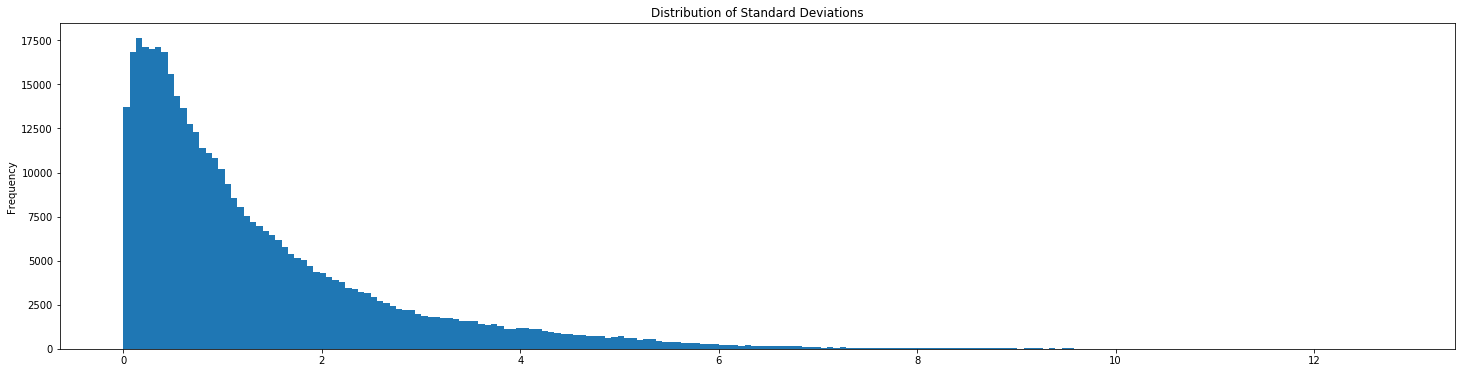

In [25]:
#Make copies of deviations to avoid manipulating true data
flat_deviations = deviations.flatten()
print("Max STD: ",deviations.max())
df = pd.Series(flat_deviations)
df.plot(kind='hist', figsize = (25, 6), bins=200, title = "Distribution of Standard Deviations")

In [17]:
SAMPLE_REAL = "C:/Users/19174/Desktop/BP HPC/large_dataset_only_realizations/img_5.stack.segy"
sample_arr = np.zeros([1058, 400, 3], dtype=np.uint8)
gray_sample_arr = np.zeros((1058, 400))
with open(SAMPLE_REAL, 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            gray_sample_arr[trace_index, i] = data[i]
with open(SAMPLE_REAL, 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            sample_arr[trace_index, i] = [data[i], 0, 0] #Collecting data for sample_arr

min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255
for i in range(len(gray_sample_arr)):
    for j in range(len(gray_sample_arr[0])):
        sample_arr[i][j] = [gray_sample_arr[i][j], gray_sample_arr[i][j], gray_sample_arr[i][j]]

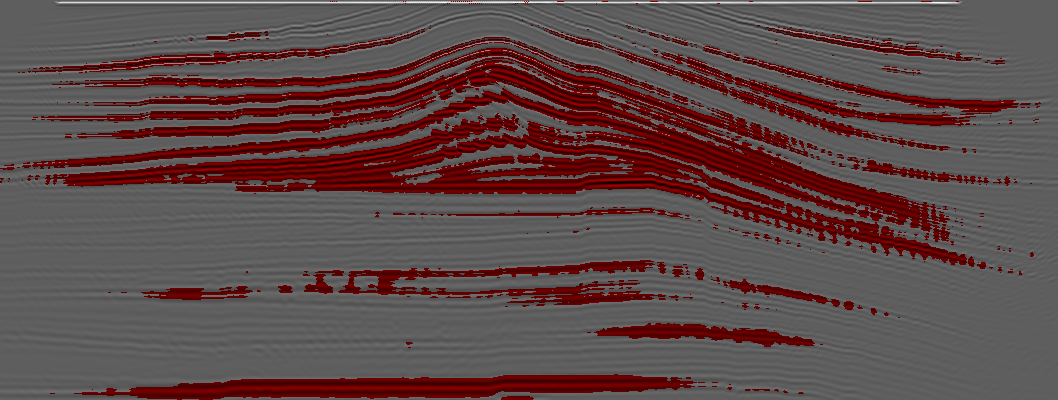

In [28]:
THRESHOLD = 2.0 #If STD > THRESHOLD plot
deviations_copy = deviations.copy()
for i in range(len(deviations_copy)):
    for j in range(len(deviations_copy[0])):
        if deviations_copy[i][j] >= THRESHOLD:
            color_intensity = sample_arr[i][j][0]
            sample_arr[i][j] = [color_intensity, 0, 0]

im = Image.fromarray(sample_arr)
im = im.convert('RGB')
transposed  = im.transpose(Image.ROTATE_270)


transposed

In [ ]:
gray_sample_arr = gray_sample_arr.transpose() #Reformat 
min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255  #Multiply everything to RGB Scale
im = Image.fromarray(gray_sample_arr)
im = im.convert('RGB')

im

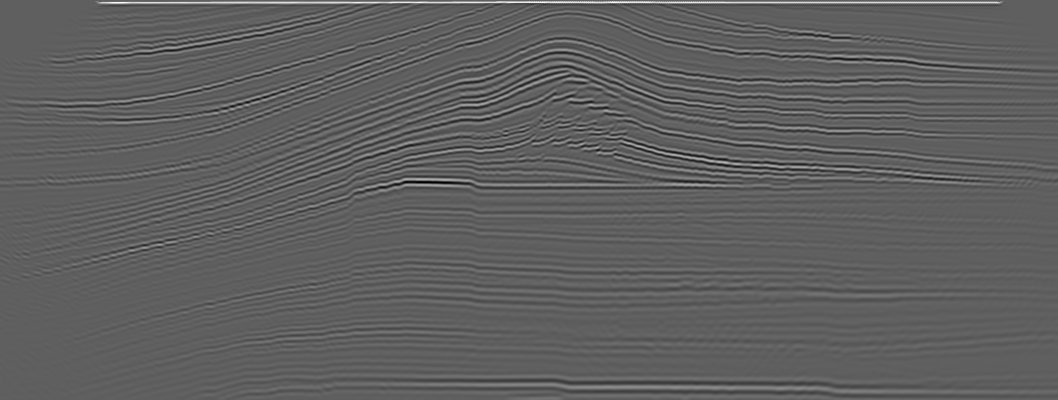

In [13]:
gray_sample_arr = np.zeros((1058, 400))
with open("C:/Users/19174/Desktop/BP HPC/small_dataset/small_dataset/img_1.stack.segy", 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            gray_sample_arr[trace_index, i] = data[i]
gray_sample_arr = gray_sample_arr.transpose() #Reformat 
min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255  #Multiply everything to RGB Scale
im = Image.fromarray(gray_sample_arr)
im = im.convert('RGB')

im

# SSIM Across Tiles 
Calculate SSIM for tiles across the realizations.

In [93]:
with open('mean_ssim_quick.pickle', 'rb') as f: #Approach: SSIM across 2 matrices, multichannel = False
    ans = pickle.load(f)

In [34]:
with open('ssim_map.pickle', 'rb') as f: #Approach: Convert matrix to image, multichannel = True
     ssim_map = pickle.load(f) 

In [ ]:
REALS = 39
map_reals = {}
for _ in range(1, REALS + 1):
    path = "C:/Users/19174/Desktop/BP HPC/small_dataset/small_dataset/img_" + str(_) +  ".stack.segy"
    print(path)
    arr = np.zeros((1058, 400))
    with open(path, 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')
        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i] #Collecting data for sample_arr
    map_reals[_] = arr


In [ ]:
#Template of breaking up a single realization into 23X20 tiles
#Don't actually need to run
hori_size = 46
vert_size = 20
ans = []
for i in range(int(1058 / hori_size)):
    test = []
    for j in range(int(400 /vert_size)):
        test.append([])
    ans.append(test)
REALS = 39
for _ in range(1, REALS + 1):
    for temp in range(_ + 1, REALS + 1):
        first_data = map_reals[_]
        second_data = map_reals[temp]
        print(_, temp)
        x_index = 0
        y_index = 0
        for i in range(0, 1058, hori_size):
            for j in range(0, 400 , vert_size):
                first_map = np.zeros((hori_size,vert_size))
                second_map = np.zeros((hori_size,vert_size))
                #k and m responsible for partition array
                for k in range(i, i + hori_size):
                    data1 = first_data[k]
                    data2 = second_data[k]
                    for m in range(j, j + vert_size): #Loop sets matrix to these elements
                        x = k% hori_size
                        y = m % vert_size
                        first_map[x, y] = data1[m]
                        second_map[x, y] = data2[m]
                s = ssim(first_map, second_map, multichannel= False)
                ans[x_index][y_index].append(s)
                y_index += 1
            x_index += 1
            y_index = 0
for i in range(len(ssim_map)):
    for j in range(len(ssim_map[0])):
        ans[i][j] = np.mean(ans[i][j])


In [ ]:
for i in range(len(ssim_map)):
    for j in range(len(ssim_map[0])):
        ans[i][j] = np.mean(ans[i][j])
print(ans)

In [ ]:
with open('ssim_map.pickle', 'wb') as f:
    pickle.dump(ans, f)

In [91]:
with open('mean_ssim_quick.pickle', 'wb') as f:
    pickle.dump(ans, f)

In [35]:
for i in range(len(ssim_map)):
    for j in range(len(ssim_map[0])):
        ssim_map[i][j] = np.mean(ssim_map[i][j])

In [30]:
SAMPLE_REAL = "C:/Users/19174/Desktop/BP HPC/large_dataset_only_realizations/img_5.stack.segy"
sample_arr = np.zeros([1058, 400, 3], dtype=np.uint8)
gray_sample_arr = np.zeros((1058, 400))
with open(SAMPLE_REAL, 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            gray_sample_arr[trace_index, i] = data[i]
min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255
for i in range(len(gray_sample_arr)):
    for j in range(len(gray_sample_arr[0])):
        sample_arr[i][j] = [gray_sample_arr[i][j], gray_sample_arr[i][j], gray_sample_arr[i][j]]


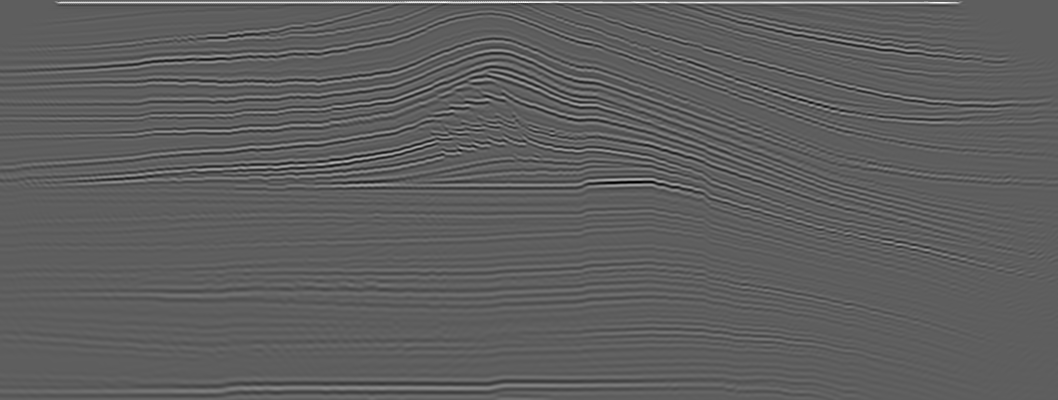

In [31]:
im = Image.fromarray(sample_arr)
im = im.convert('RGB')
transposed  = im.transpose(Image.ROTATE_270)
transposed

In [103]:
THRESHOLD = .7
min_val = float('inf')
max_val = -float('inf')
for subarray in ans:
    for element in subarray:
        min_val = min(min_val, element)
        if element <= THRESHOLD:
            max_val = max(max_val, element)
ans_image = np.zeros([1058, 400, 4], dtype=np.uint8)
for i in range(23):
    for j in range(20):
        if ans[i][j] <= THRESHOLD:
            color_intensity = (ans[i][j] - min_val) / (max_val - min_val) * 255
            for k in range(i * 46, i*46 + 46):
                for m in range(j * 20, j* 20 + 20):
                    ans_image[k][m] = [color_intensity, 0, 0, 255] 
        else:
            for k in range(i * 46, i*46 + 46):
                for m in range(j * 20, j* 20 + 20):
                    ans_image[k][m] = [0, 0, 0, 0] #Make pixel transparent

im2 = Image.fromarray(ans_image)
im2 = im2.convert('RGBA')
transposed2 = im2.transpose(Image.ROTATE_270)

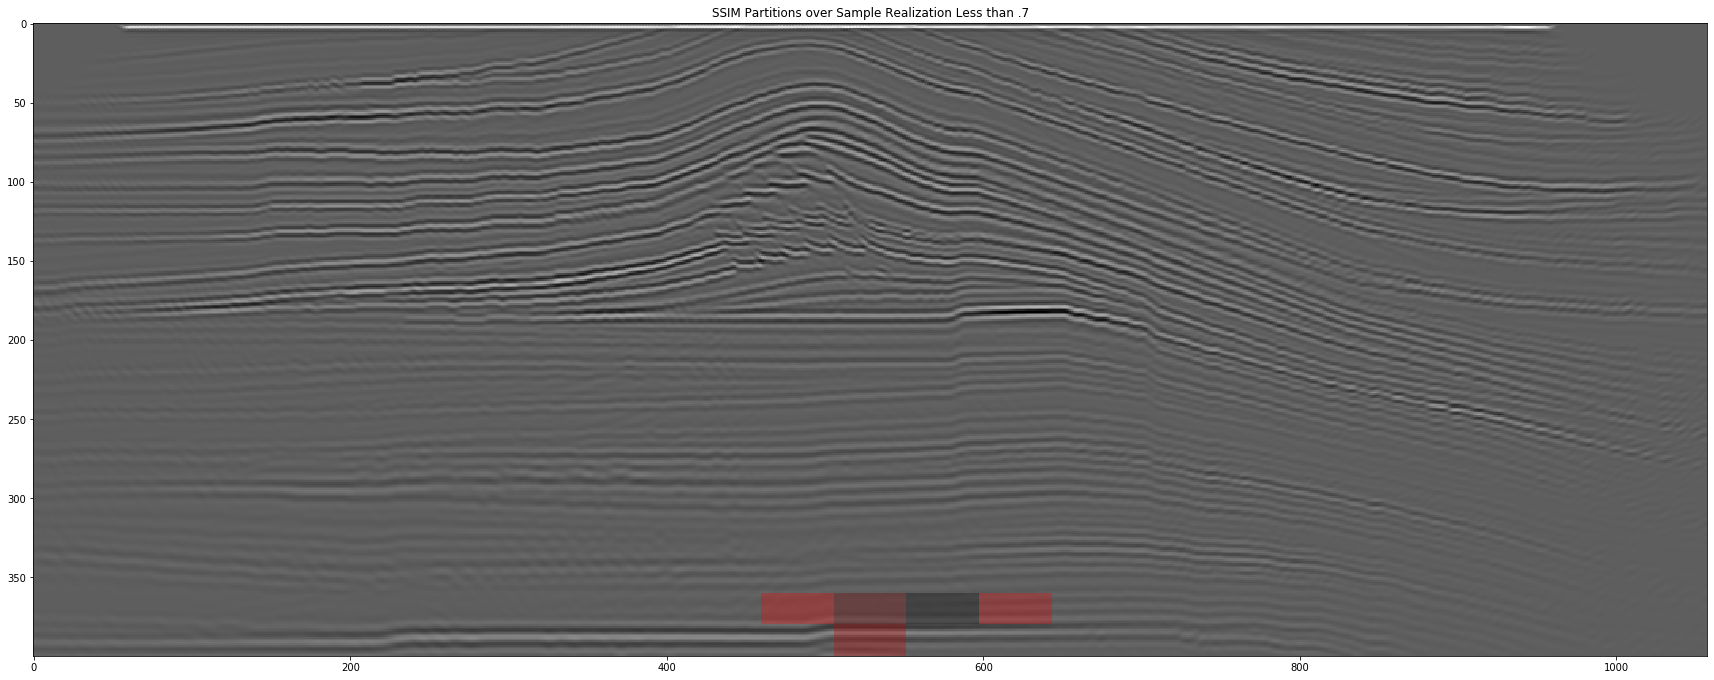

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.imshow(transposed, cmap='gray') # I would add interpolation='none'
plt.title("SSIM Partitions over Sample Realization Less than .7")
plt.imshow(transposed2, cmap='jet', alpha=.3) # interpolation='none'

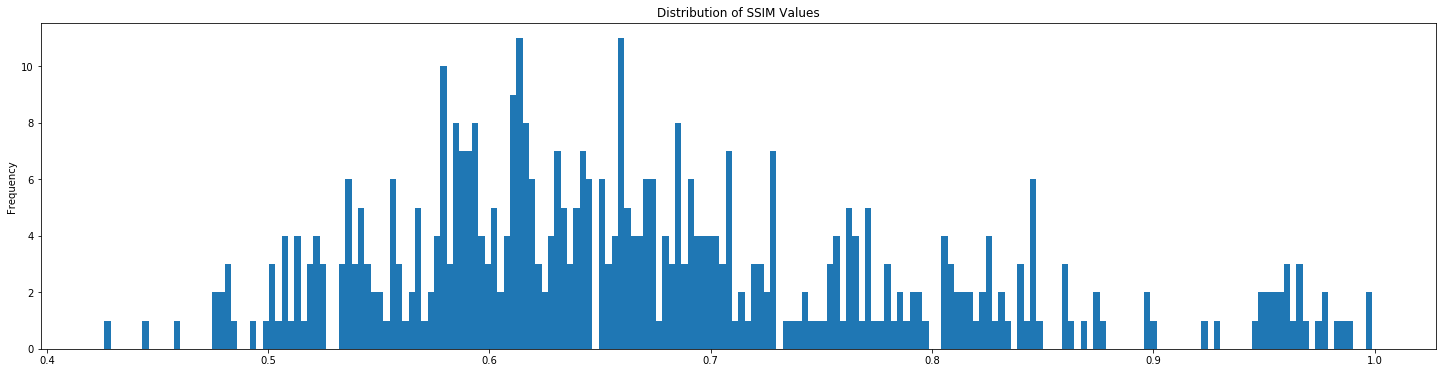

In [105]:
test = []
for i in range(len(ans)):
    for j in range(len(ans[0])):
        test.append(ans[i][j])
df = pd.Series(test)
df.plot(kind='hist', figsize = (25, 6), bins=200, title = "Distribution of SSIM Values")

In [106]:
THRESHOLD = .7
min_val = float('inf')
max_val = -float('inf')
for subarray in ssim_map:
    for element in subarray:
        min_val = min(min_val, element)
        if element <= THRESHOLD:
            max_val = max(max_val, element)
ssim_image = np.zeros([1058, 400, 4], dtype=np.uint8)
for i in range(23):
    for j in range(20):
        if ssim_map[i][j] <= THRESHOLD:
            color_intensity = (ssim_map[i][j] - min_val) / (max_val - min_val) * 255
            for k in range(i * 46, i*46 + 46):
                for m in range(j * 20, j* 20 + 20):
                    ssim_image[k][m] = [color_intensity, 0, 0, 255] 
        else:
            for k in range(i * 46, i*46 + 46):
                for m in range(j * 20, j* 20 + 20):
                    ssim_image[k][m] = [0, 0, 0, 0] #Make pixel transparent

im2 = Image.fromarray(ssim_image)
im2 = im2.convert('RGBA')
transposed2 = im2.transpose(Image.ROTATE_270)


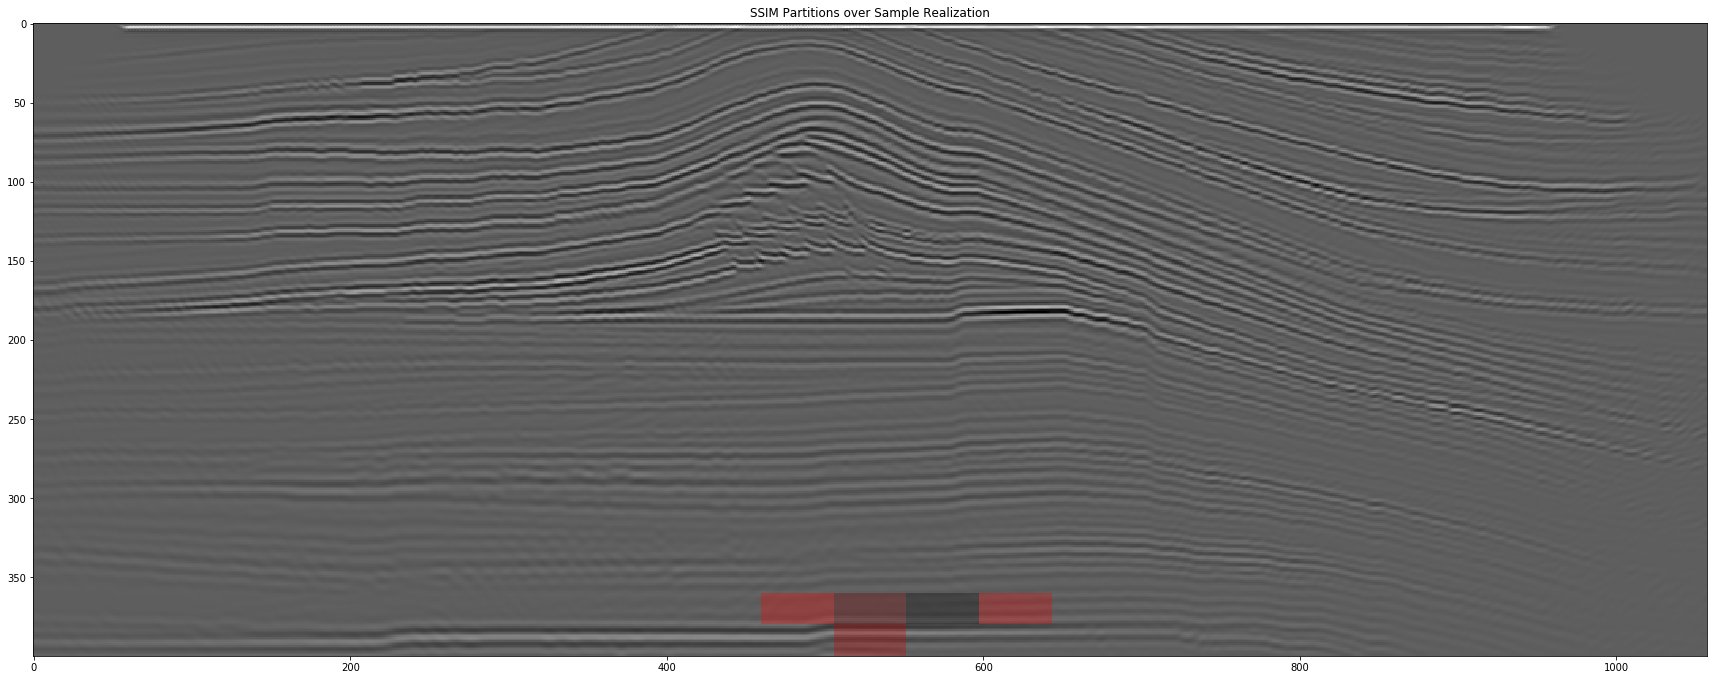

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.imshow(transposed, cmap='gray') # I would add interpolation='none'
plt.title("SSIM Partitions over Sample Realization Less than .7")
plt.imshow(transposed2, cmap='jet', alpha=.3) # interpolation='none'

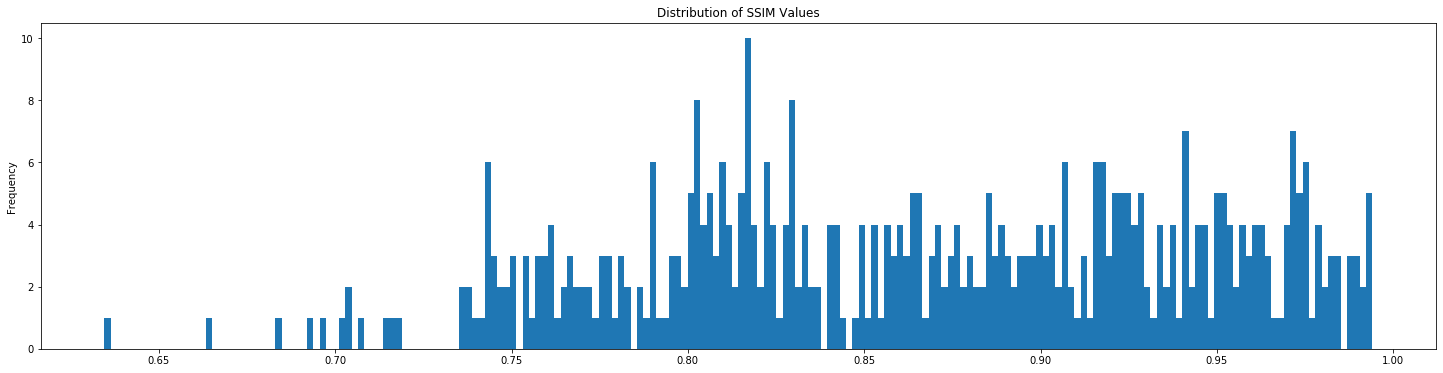

In [108]:
test = []
for i in range(len(ssim_map)):
    for j in range(len(ssim_map[0])):
        test.append(ssim_map[i][j])
df = pd.Series(test)
df.plot(kind='hist', figsize = (25, 6), bins=200, title = "Distribution of SSIM Values")

In [ ]:
"""
The provided files ending with a .gather.segy suffix store offset pair gathers generated
using some plausible (but not perfect) velocity model. Each offset pair gather file corresponds
with a single realization.

These gather files are 3D, with 39 offset pairs in the survey. The z and x dimensions are the
same as the realizations, with an added dimension indicating the offset pair. This information
can be seen in the SEGY header displayed below.
"""
print_segy_info('Desktop/BP HPC/small_dataset/small_dataset/img_3.gather.segy')

In [ ]:
"""
Load gathers into a 3D numpy array with dimensions (x, offsets, z).
"""
arr = np.zeros((1058, 39, 400))
with open('Desktop/BP HPC/small_dataset/small_dataset/img_3.gather.segy', 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    
    count = 0
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            arr[int(trace_index / 39), trace_index % 39, i] = data[i]


In [ ]:
arr.min(), arr.max()

In [ ]:
"""
Render the loaded gathers.
"""

nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 25))

for c in range(ncols):
    # Pull out all offset pairs for a given x
    sub_arr = arr[c, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())